Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Bắt đầu phân tích tương quan giữa VCB và VNINDEX...
KẾT QUẢ PHÂN TÍCH TƯƠNG QUAN GIỮA VCB VÀ VNINDEX

TOP TƯƠNG QUAN VỚI GIÁ ĐÓNG CỬA VCB:
close_vcb                    1.000000
high_vcb                     0.994894
low_vcb                      0.991997
open_vcb                     0.988698
ma_20_vcb                    0.910493
macd_vnindex                 0.632296
macd_vcb                     0.470535
low_vnindex                  0.431165
close_vnindex                0.429275
open_vnindex                 0.423813
high_vnindex                 0.421046
rsi_14_vnindex               0.351556
ma_20_vnindex                0.347450
volume_vnindex               0.334554
rsi_14_vcb                   0.247023
volume_vcb                   0.117221
close_pct_change_vnindex     0.107203
close_pct_change_vcb         0.083184
volume_pct_change_vcb       -0.003161
volume_pct

<ipython-input-31-b1e7417153fb>:167: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



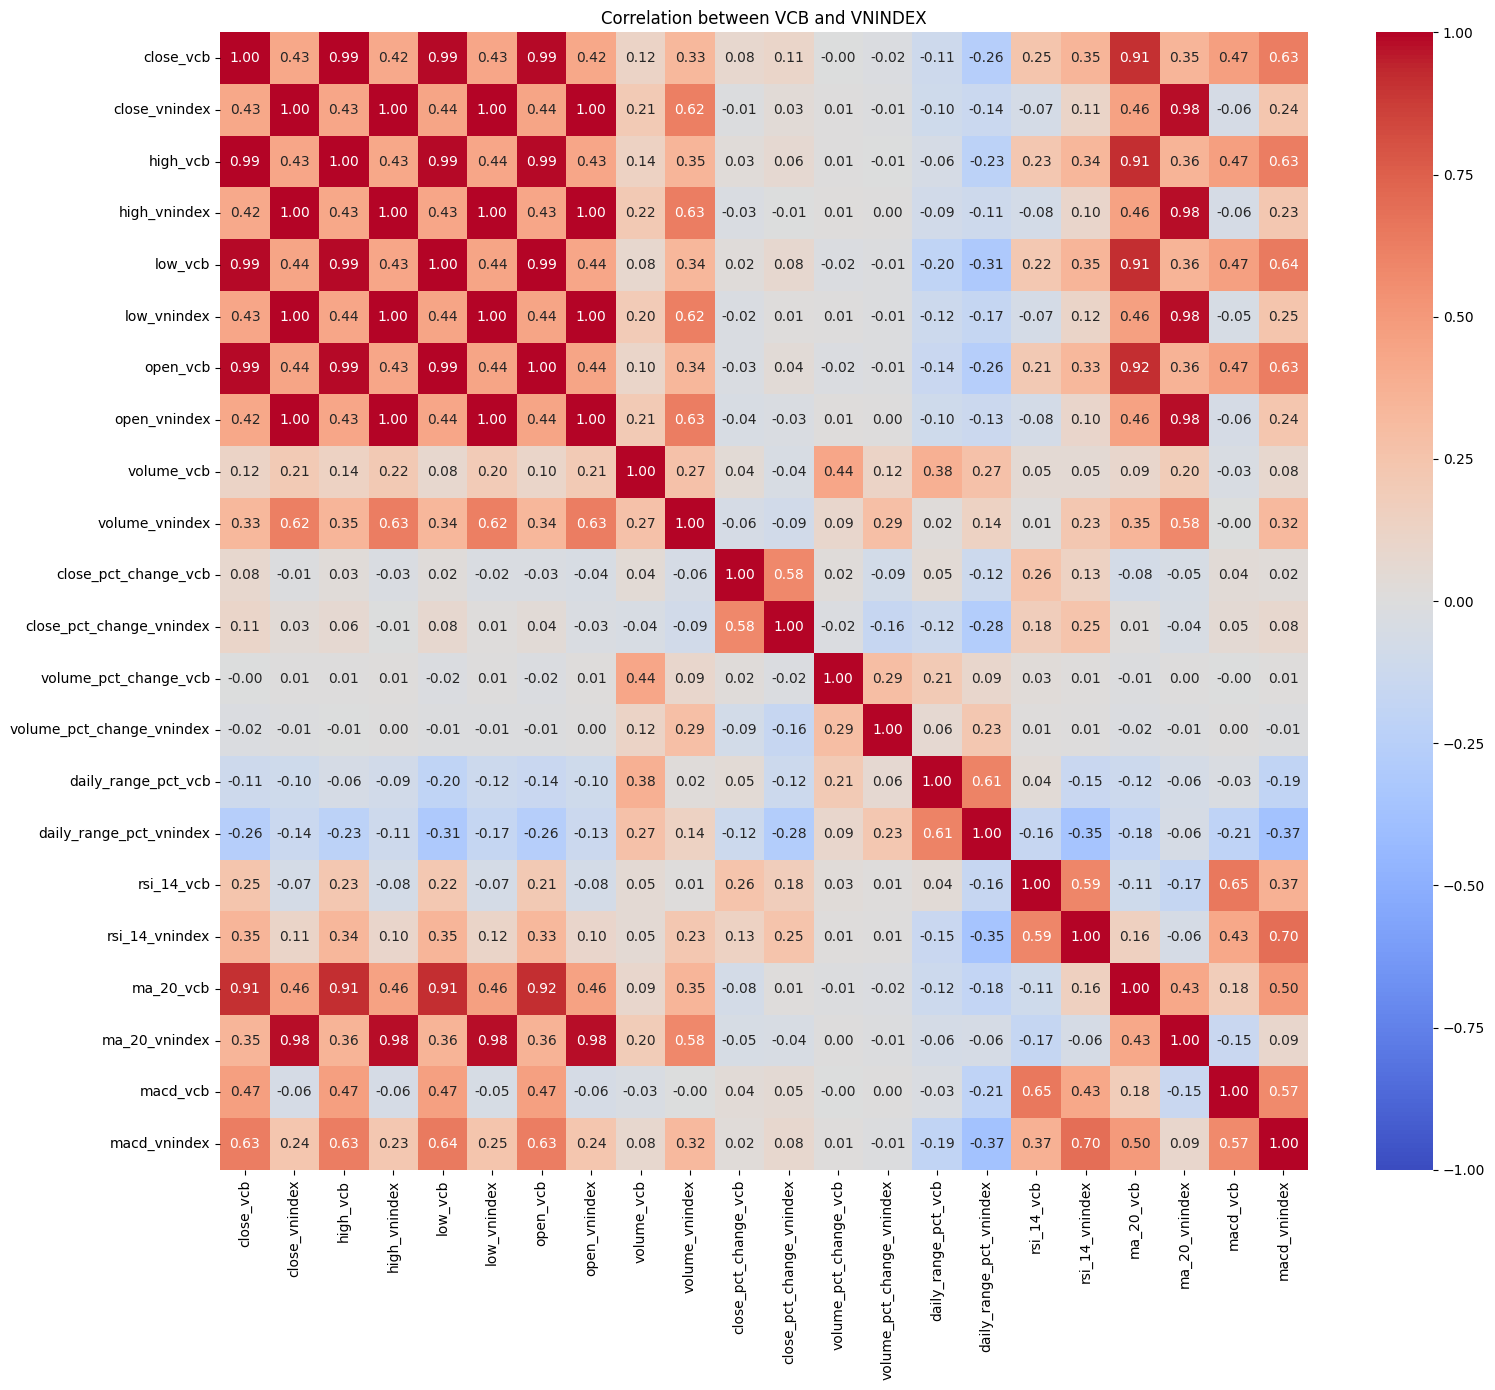

Đã lưu biểu đồ tương quan: correlation_heatmap.png


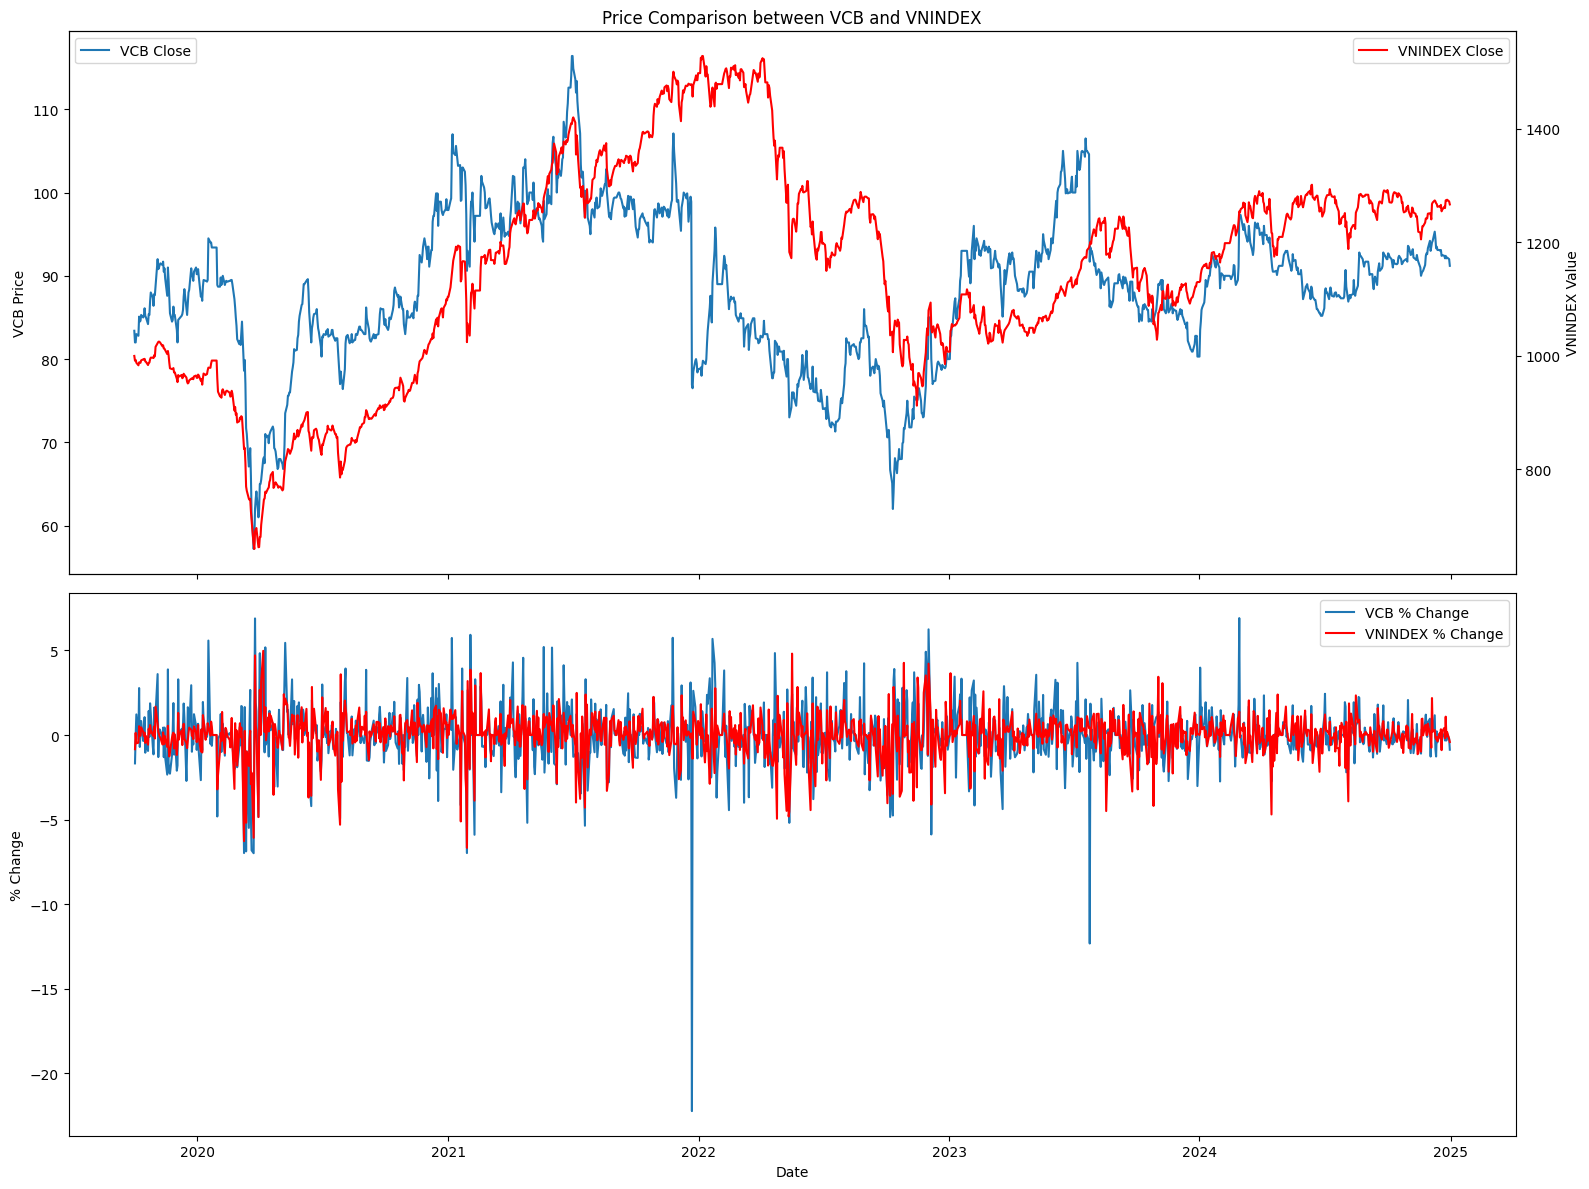

Đã lưu biểu đồ so sánh: price_comparison.png


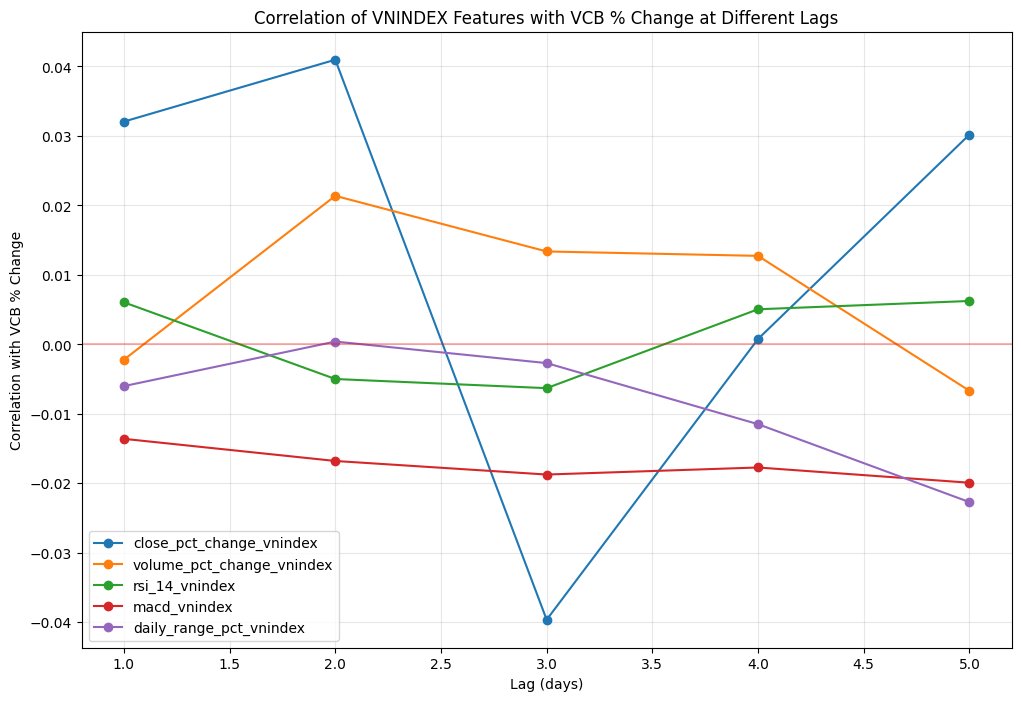

Đã lưu biểu đồ tương quan độ trễ: lag_correlation.png
Phân tích hoàn tất!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import drive

drive.mount('/content/drive')
filepath="/content/drive/MyDrive/Colab Notebooks"


    # Đọc dữ liệu VCB và VNINDEX
def load_data(filepath, vcb_file, vnindex_file):
    # Đọc dữ liệu từ file CSV
    vcb_df = pd.read_csv(f"{filepath}/Stock_VCB_filled.csv")
    vnindex_df = pd.read_csv(f"{filepath}/Stock_VNindex_filled.csv")

    # Chuyển đổi cột date thành datetime
    vcb_df['date'] = pd.to_datetime(vcb_df['date'])
    vnindex_df['date'] = pd.to_datetime(vnindex_df['date'])

    # Đổi tên cột volume_match thành volume để dễ sử dụng
    vcb_df = vcb_df.rename(columns={'volume_match': 'volume'})
    vnindex_df = vnindex_df.rename(columns={'volume_match': 'volume'})

    # Đảm bảo dữ liệu được sắp xếp theo ngày
    vcb_df = vcb_df.sort_values('date')
    vnindex_df = vnindex_df.sort_values('date')
    return vcb_df, vnindex_df


# Tạo các tính năng phái sinh
def create_features(df):
    # Tính % thay đổi giá đóng cửa
    df['close_pct_change'] = df['close'].pct_change() * 100

    # Tính % thay đổi giá mở cửa
    df['open_pct_change'] = df['open'].pct_change() * 100

    # Tính % thay đổi khối lượng giao dịch
    df['volume_pct_change'] = df['volume'].pct_change() * 100

    # Tính biên độ dao động trong ngày
    df['daily_range'] = df['high'] - df['low']
    df['daily_range_pct'] = df['daily_range'] / df['close'] * 100

    # Tính RSI 14 ngày (đơn giản)
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi_14'] = 100 - (100 / (1 + rs))

    # Tính MA 20 ngày
    df['ma_20'] = df['close'].rolling(window=20).mean()

    # Tính MACD
    df['ema_12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['ema_26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    return df


# Phân tích tương quan
def analyze_correlation(vcb_df, vnindex_df):
    # Chỉ giữ lại các ngày có cả dữ liệu VCB và VNINDEX
    merged_df = pd.merge(vcb_df, vnindex_df, on='date', suffixes=('_vcb', '_vnindex'))

    # Chọn các cột để phân tích tương quan
    correlation_columns = [
        'close_vcb', 'close_vnindex',
        'high_vcb', 'high_vnindex',
        'low_vcb', 'low_vnindex',
        'open_vcb', 'open_vnindex',
        'volume_vcb', 'volume_vnindex',
        'close_pct_change_vcb', 'close_pct_change_vnindex',
        'volume_pct_change_vcb', 'volume_pct_change_vnindex',
        'daily_range_pct_vcb', 'daily_range_pct_vnindex',
        'rsi_14_vcb', 'rsi_14_vnindex',
        'ma_20_vcb', 'ma_20_vnindex',
        'macd_vcb', 'macd_vnindex'
    ]

    # Tính ma trận tương quan
    correlation_matrix = merged_df[correlation_columns].corr()

    return merged_df, correlation_matrix


# Vẽ biểu đồ tương quan
def plot_correlation(correlation_matrix, title):
    plt.figure(figsize=(16, 14))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.savefig('correlation_heatmap.png')
    plt.close()
    print(f"Đã lưu biểu đồ tương quan: correlation_heatmap.png")


# Vẽ biểu đồ so sánh
def plot_comparison(merged_df, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

    # Vẽ biểu đồ giá đóng cửa
    ax1.plot(merged_df['date'], merged_df['close_vcb'], label='VCB Close')
    ax1.set_ylabel('VCB Price')
    ax1.legend(loc='upper left')

    # Tạo trục y thứ hai cho VNINDEX
    ax1_twin = ax1.twinx()
    ax1_twin.plot(merged_df['date'], merged_df['close_vnindex'], 'r-', label='VNINDEX Close')
    ax1_twin.set_ylabel('VNINDEX Value')
    ax1_twin.legend(loc='upper right')

    # Vẽ biểu đồ % thay đổi
    ax2.plot(merged_df['date'], merged_df['close_pct_change_vcb'], label='VCB % Change')
    ax2.plot(merged_df['date'], merged_df['close_pct_change_vnindex'], 'r-', label='VNINDEX % Change')
    ax2.set_ylabel('% Change')
    ax2.set_xlabel('Date')
    ax2.legend()

    plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.savefig('price_comparison.png')
    plt.close()
    print(f"Đã lưu biểu đồ so sánh: price_comparison.png")


# Hàm tạo các tính năng độ trễ
def create_lag_features(df, columns, lags):
    for col in columns:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df


# Phân tích tương quan với độ trễ
def analyze_lag_correlation(merged_df):
    # Chọn cột để phân tích độ trễ
    lag_columns = [
        'close_pct_change_vnindex',
        'volume_pct_change_vnindex',
        'rsi_14_vnindex',
        'macd_vnindex',
        'daily_range_pct_vnindex'
    ]
    target_column = 'close_pct_change_vcb'

    # Tạo DataFrame để lưu kết quả
    lag_correlation_df = pd.DataFrame(columns=['Feature', 'Lag', 'Correlation'])

    # Tính tương quan với mỗi độ trễ
    for lag in range(1, 6):  # Độ trễ từ 1 đến 5 ngày
        for col in lag_columns:
            lagged_col = f'{col}_lag_{lag}'
            merged_df[lagged_col] = merged_df[col].shift(lag)

            # Tính tương quan
            correlation = merged_df[[target_column, lagged_col]].corr().iloc[0, 1]

            # Thêm vào DataFrame kết quả
            lag_correlation_df = lag_correlation_df._append({
                'Feature': col,
                'Lag': lag,
                'Correlation': correlation
            }, ignore_index=True)

    return lag_correlation_df


# Vẽ biểu đồ tương quan với độ trễ
def plot_lag_correlation(lag_correlation_df):
    plt.figure(figsize=(12, 8))

    for feature in lag_correlation_df['Feature'].unique():
        feature_data = lag_correlation_df[lag_correlation_df['Feature'] == feature]
        plt.plot(feature_data['Lag'], feature_data['Correlation'], marker='o', label=feature)

    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.xlabel('Lag (days)')
    plt.ylabel('Correlation with VCB % Change')
    plt.title('Correlation of VNINDEX Features with VCB % Change at Different Lags')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    plt.savefig('lag_correlation.png')
    plt.close()
    print(f"Đã lưu biểu đồ tương quan độ trễ: lag_correlation.png")


# Hàm để phân tích và lưu kết quả tương quan
def save_correlation_results(correlation_matrix, lag_correlation_df, output_file='correlation_results.txt'):
    results = []

    results.append("KẾT QUẢ PHÂN TÍCH TƯƠNG QUAN GIỮA VCB VÀ VNINDEX")
    results.append("=" * 50 + "\n")

    # Tương quan với giá đóng cửa VCB
    results.append("TOP TƯƠNG QUAN VỚI GIÁ ĐÓNG CỬA VCB:")
    vcb_close_corr = correlation_matrix['close_vcb'].sort_values(ascending=False)
    results.append(vcb_close_corr.to_string() + "\n")

    # Tương quan với % thay đổi giá VCB
    results.append("TOP TƯƠNG QUAN VỚI % THAY ĐỔI GIÁ VCB:")
    vcb_pct_change_corr = correlation_matrix['close_pct_change_vcb'].sort_values(ascending=False)
    results.append(vcb_pct_change_corr.to_string() + "\n")

    # Tương quan với độ trễ
    results.append("TOP TƯƠNG QUAN VỚI ĐỘ TRỄ:")
    top_lag_corr = lag_correlation_df.sort_values('Correlation', ascending=False)
    results.append(top_lag_corr.to_string(index=False) + "\n")

    # Khuyến nghị cho mô hình
    results.append("KHUYẾN NGHỊ CHỈ SỐ CHO MÔ HÌNH:")
    results.append("Dựa trên phân tích tương quan, các chỉ số sau của VNINDEX có tương quan cao với VCB:")

    # Lọc ra các chỉ số VNINDEX có tương quan cao với VCB
    vnindex_features = [col for col in correlation_matrix.columns if col.endswith('_vnindex')]
    high_corr_features = []

    for feature in vnindex_features:
        corr_value = correlation_matrix.loc['close_vcb', feature]
        if abs(corr_value) > 0.3:  # Ngưỡng tương quan
            high_corr_features.append((feature, corr_value))

    # Sắp xếp theo độ tương quan giảm dần
    high_corr_features.sort(key=lambda x: abs(x[1]), reverse=True)

    # Viết danh sách các chỉ số có tương quan cao
    for feature, corr in high_corr_features:
        results.append(f"- {feature}: {corr:.4f}")

    # Lấy top 5 chỉ số có tương quan cao nhất với độ trễ
    results.append("\nChỉ số VNINDEX có tương quan cao nhất với độ trễ:")
    top_5_lag = lag_correlation_df.sort_values('Correlation', ascending=False).head(5)
    for _, row in top_5_lag.iterrows():
        results.append(f"- {row['Feature']} (độ trễ {row['Lag']} ngày): {row['Correlation']:.4f}")

    # Ghi vào file
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write("\n".join(results))

    # In ra màn hình
    print("\n".join(results))
    print(f"\nĐã lưu kết quả phân tích tương quan: {output_file}")


def main(vcb_file_path, vnindex_file_path):
    print("Bắt đầu phân tích tương quan giữa VCB và VNINDEX...")

    # Đọc dữ liệu
    # Pass filepath to load_data
    vcb_df, vnindex_df = load_data(filepath, vcb_file_path, vnindex_file_path)

    # Tạo các tính năng phái sinh cho cả hai tập dữ liệu
    vcb_df = create_features(vcb_df)
    vnindex_df = create_features(vnindex_df)

    # Phân tích tương quan
    merged_df, correlation_matrix = analyze_correlation(vcb_df, vnindex_df)

    # Phân tích độ trễ
    lag_correlation_df = analyze_lag_correlation(merged_df)

    # Lưu kết quả phân tích tương quan ra file
    save_correlation_results(correlation_matrix, lag_correlation_df, output_file='correlation_results.txt')

    # Vẽ biểu đồ tương quan và so sánh
    plot_correlation(correlation_matrix, title="Correlation between VCB and VNINDEX")
    plot_comparison(merged_df, title="Price Comparison between VCB and VNINDEX")
    plot_lag_correlation(lag_correlation_df)

    print("Phân tích hoàn tất!")

if __name__ == "__main__":
    vcb_file = "vcb.csv"
    vnindex_file = "vnindex.csv"
    main(vcb_file, vnindex_file)
